#  MAP 554 / TP1 -  Lab 2: Opitmization with population-based algorithms


This notebook is written as an introdcution to population-based algorithms for optimization with Python


This notebook consists of three parts:
- Design of a genetic algorithm (GA)
- Use of package `Inspyred` for GA and PSO
- Handling of constraints
- Exercices

In [1]:
#Installation of required packages
#!pip install inspyred

## 0- Definition of test functions

`Rosenbrock`: 2D function $\mathbf{z} \rightarrow 100\times(z_2-z_1^2)^2+(1-z_1)^2$

`Ackley`: 2D function $\mathbf{z} \rightarrow -20 \exp\left({-0.2 \sqrt{0.5(z_1^2+z_2^2)}}\right) - \exp\left(0.5\cos(2\pi z_1) + 0.5\cos(2\pi z_2)\right) + e + 20$


In [2]:
# Support for maths
import numpy as np
import copy
import matplotlib
%matplotlib inline

def Rosenbrock(z):
    return 100*(z[1]-z[0]**2)**2+(1-z[0])**2

def Ackley(z):
    return -20 * np.exp(-0.2*np.sqrt(0.5*(z[0]**2+z[1]**2))) - np.exp(0.5*np.cos(2*np.pi*z[0])+0.5*np.cos(2*np.pi*z[1])) + np.exp(1) + 20.

In [3]:
#Optimum of the function
Optimum_Rosenbrock = np.array([1., 1.])

Optimum_Ackley = np.array([0., 0.])

## 1- Design of a genetic algorithm

A genetic algorithm consists of a initialization step and 4 interative steps:
 - Generation of the initial population
 - Step 1 : Evaluation of the population
 - Step 2 : Selection of the parents
 - Step 3 : Variation of the parents (crossover and mutation)
 - Step 4 : Selection of the new generation

### Binary coding of the population

In this part, a genetic algorithm with a binary coding of the population is considered. 
One defines a function which transformes a binary number of `dimension_bits` bits into a real number between `mini` and `maxi`

In [4]:
#Coding of individuals from binary to real
def _binary_to_real(binary,mini,maxi,dimensions,dimension_bits):
    real = []
    for d, lo, hi in zip(range(dimensions), mini,maxi):
        b = binary[d*dimension_bits:(d+1)*dimension_bits]
        real_val = float(int(''.join([str(i) for i in b]), 2))
        value = real_val / (2**(dimension_bits)-1) * (hi - lo) + lo
        real.append(value)
    return real # for one individual, dimension 2 etc. 6 bits per chromosome - min real value 0, max real value 1 for each chomosome


In [5]:
_binary_to_real([1,0,1,0,0,0,1,0,1,0,1,0],[0,0],[1,1],2,6) 

[0.6349206349206349, 0.6666666666666666]

The function `algo_genetique` follows the different steps of genetic algorithm: initialization, evaluation, selection, cross-over, mutation and replacement.

In [6]:
#Definition of genetic algorithm
def algo_genetique(f,num_generations,popsize,dim,mini,maxi,dimension_bits,proba_crossover=0.9,proba_mutation=0.1):
    
    new_population = np.array([[np.random.choice([0, 1]) for _ in range(dim* dimension_bits)] for j in range(popsize)]) # random initialization
        
    for generation in range(num_generations):# iteration over the number of generations
        
        fitness = evaluate_population(f, new_population,mini,maxi,dimension_bits) #evaluation of the population
        
        parents = select_parents(new_population,fitness) #selection of the parents
        
        off_spring= crossover(parents,proba_crossover) #cross-over of the parents
        
        off_spring = mutation(off_spring,proba_mutation) # mutation
        
        new_population = np.concatenate((new_population,off_spring))
        new_population = truncate(f,new_population,mini,maxi,dimension_bits) #selection of the new generation
    return new_population

- Evaluation of the population : Definition of the function that will be used to evaluate the objective function on the current population `evaluate_population`. 

`evaluate_population` takes as argument the function that represents the fitness and the population to be evaluated. 

In [7]:
# Function used to evaluate the population
def evaluate_population(f, pop, mini,maxi,dimension_bits):
    fitness=np.zeros((len(pop),1))
    dimensions = pop.shape[1]
    for i in range(len(pop)):
        real_value = _binary_to_real(pop[i].astype(int),mini,maxi,dimensions,dimension_bits)
        fitness[i] =10000 - f(real_value)
    return fitness    

- Selection of the parents: definition of the function used to select the parents `select_parents`. 

`select_parents` takes as arguments the current population, the fitness of each individual. It returns the parents to be mutated and crossed-over. The selection method here is the roulette wheel.

In [8]:
# Function of selection, takes as inputs the current population and the fitness
def select_parents(pop, fitness):
    sum_fitness = np.sum(fitness)
    proba = np.zeros((len(pop),1))
    for i in range(len(pop)):
        proba[i] = np.sum(fitness[:i+1])/sum_fitness  # empirical CDF of the fitness values
        parents = pop
    for parent_num in range(len(pop)):
        r=np.random.rand() #on tire un nombre aléatoire entre 0 et 1
        if r<=proba[0]: 
            parents[parent_num] = pop[0]
        else:
            for i in range(len(pop)-1):
                if fitness[i]<=r<fitness[i+1]:
                    parents[parent_num] = pop[i+1]
    return parents

- Crossover of the parents:


Ones defines the crossover function for the binary coding. This function makes the cross-over between two parents by switching their genes from a random determined point.

In [9]:
#Cross over function, takes as inputs the parents and a probability of cross-over

def crossover(parents,proba_crossover):
     offspring = parents    
     for k in range(len(parents)):
         # Index of the first parent to mate.
         parent1_idx = k%parents.shape[0]
         # Index of the second parent to mate.
         parent2_idx = (k+1)%parents.shape[0]
         # The new offspring will have its first half of its genes taken from the first parent.
         r = np.random.rand()
         crossover_point = np.random.choice(range(parents.shape[1]))
         if r<=proba_crossover: # Remark : 2 parents -> 2 children.
             offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
             # The new offspring will have its second half of its genes taken from the second parent.
             offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
     return offspring

- Mutation:

Ones defines the mutation function for the binary coding. This function inverts a bit randomly

In [10]:
#Mutation function, takes as inputs the offsprings and a probability of mutation
def mutation(off_spring,proba_mutation):
    for idx in range(off_spring.shape[0]):
        k = np.random.choice(range(off_spring.shape[1]))
        r = np.random.rand()
        if r<=proba_mutation:
            off_spring[idx, k] = (off_spring[idx, k] +1)%2
    return off_spring

- Selection of the new generation: definition of the truncature function  `truncate`. 

`truncate` takes as arguments the current population and the fitness function. The coded approach selects the individuals with the best fitness (elitist)

In [11]:
#Selection function
def truncate(f , population,mini,maxi,dimension_bits):
    pop_size=int(len(population)/2)
    population=np.array(population)
    population=population.astype(int)
    fitness=evaluate_population(f, population,mini,maxi,dimension_bits)
    new_generation = np.empty((pop_size, population.shape[1]))
    for pop_num in range(pop_size):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        new_generation[pop_num, :] = population[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return new_generation

In [12]:
#Run of the genetic algorithm on the Rosenbrock function
results=algo_genetique(Rosenbrock,20,20,2,[-1,-1],[2.,2.],8)
fitness=evaluate_population(Rosenbrock, results,[-1,-1],[2.,2.],8)
10000-fitness.max()

0.0005842841928824782

### Real coding
 
In the following, a real coding genetic algorithm is described


In [40]:
#Generic definition of genetic algorithm, takes as inputs the function to optimize, the number of generations
# the size of the population, the bounds on the opimization variables and the probabilities of cross over and mutation
    
def algo_genetique(f,num_generations,popsize,dim, mini,maxi , proba_crossover=0.9,proba_mutation=0.1):
    new_population = np.random.uniform(low=np.array([-2.0,-1.0]), high=np.array([2.0,3.0]), size=(popsize,dim))
    
    for generation in range(num_generations): # loop over the number of generations
        
        fitness = evaluate_population(f, new_population) #evaluation of the population
        
        parents = select_parents(new_population,fitness) #selection of the  parents
        
        off_spring_crossover = crossover(parents,proba_crossover, mini,maxi) #cross over of the parents
        
        off_spring = mutation(off_spring_crossover,proba_mutation) # mutation
        
        new_population = np.concatenate((new_population,off_spring)) 
        new_population = truncate(f,new_population) #selection of the new generation
        
    return new_population        

- Evaluation of the population: Definition of the population evaluation function `evaluate_population`. 

`evaluate_population` takes as arguments the function to be optimized and the current population 


In [41]:
def evaluate_population(f, pop):
    fitness=np.zeros((len(pop),1))
    for i in range(len(pop)):
        fitness[i] =10000 - f(pop[i]) # transformation of the minimization problem into a maximization problem for the selection step
    return fitness

- Selection of the parents: definition of the function used to select the parents `select_parents`. 

`select_parents` takes as arguments the current population, the fitness of each individual. It returns the parents to be mutated and crossed-over. The selection method here is the roulette wheel.

In [42]:
# Fonction de sélection, prend en entrée la population et la fitness de celle ci
def select_parents(pop, fitness):
    sum_fitness = np.sum(fitness)
    proba = np.zeros((len(pop),1))
    for i in range(len(pop)):
        proba[i] = np.sum(fitness[:i+1])/sum_fitness  #empirical CDF of the fitness
    parents = pop
    for parent_num in range(len(pop)):
        r=np.random.rand() #generation of random number between 0 and 1
        if r<=proba[0]: 
            parents[parent_num] = pop[0]
        else:
            for i in range(len(pop)-1):
                if fitness[i]<=r<fitness[i+1]:
                    parents[parent_num] = pop[i+1]
    return parents

- Crossover of the parents: Definition of the `crossover` function

`crossover` takes as inputs the liste of parents and a probability of crossover. The coded approach is the simulated binary crossover.

In [43]:
def crossover(parents,proba_crossover, mini,maxi):
    children = copy.copy(parents)
    for k in range(len(children)):
        if k%2==0:
            if np.random.random() < proba_crossover:
                dad_idx = np.random.choice(range(len(parents)))
                mom_idx = np.random.choice(range(len(parents)))
                dad = parents[dad_idx]
                mom = parents[mom_idx]
                di = 10.
                bro = copy.copy(dad)
                sis = copy.copy(mom)
                for i, (m, d, lb, ub) in enumerate(zip(mom, dad, mini, maxi)):
                    try:
                        if m > d:
                            m, d = d, m
                        beta = 1.0 + 2 * min(m - lb, ub - d) / float(d - m)
                        alpha = 2.0 - 1.0 / beta**(di + 1.0)
                        u = np.random.random() 
                        if u <= (1.0 / alpha):
                            beta_q = (u * alpha)**(1.0 / float(di + 1.0))
                        else:
                            beta_q = (1.0 / (2.0 - u * alpha))**(1.0 / float(di + 1.0))
                        bro_val = 0.5 * ((m + d) - beta_q * (d - m)) #weighted sum between the father and mother
                        bro_val = max(min(bro_val, ub), lb)        
                        sis_val = 0.5 * ((m + d) + beta_q * (d - m)) #weighted sum between the father and mother
                        sis_val = max(min(sis_val, ub), lb)
                        if np.random.random() > 0.5:
                            bro_val, sis_val = sis_val, bro_val
                        if np.isnan(bro_val)==False:
                            bro[i] = bro_val
                        if np.isnan(sis_val)==False:
                            sis[i] = sis_val
                    except:
                        pass
                children[k]=bro
                children[k+1]=sis
    return children

- Mutation of offsprings: definition of the `mutation` function 

`mutation` takes as inputs the list of parents and a probability of mutation. The coded appraoch allows to add a uniform random number to a selected gene.

In [44]:
# Fonction de mutation, prend en entrée une population et une probabilité de mutation
def mutation(off_spring, proba_mutation):
    for idx in range(off_spring.shape[0]):
        random_value = np.random.uniform(-1.0, 1.0, 1)
        k = np.random.choice(range(off_spring.shape[1]))
        r = np.random.rand()
        if r<=proba_mutation:
            off_spring[idx, k] = off_spring[idx, k] + random_value
    return off_spring

- Selection of the new generation: definition of the truncature function  `truncate`. 

`truncate` takes as arguments the current population and the fitness function. The coded approach selects the individuals with the best fitness (elitist)

In [45]:
def truncate(f , population):
    pop_size=int(len(population)/2)
    fitness=evaluate_population(f, population)
    new_generation = np.empty((pop_size, population.shape[1]))
    for pop_num in range(pop_size):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        new_generation[pop_num, :] = population[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return new_generation

In [50]:
# Run of genetic algorithm on the Rosenbrock function
final_pop=algo_genetique(Rosenbrock,5,20,2,[-2.0,-1.0],[2.,3.],0.0,0.9)
fitness=evaluate_population(Rosenbrock, results)
10000-fitness.max()
print(Rosenbrock(final_pop[0]))

0.3253526533660462


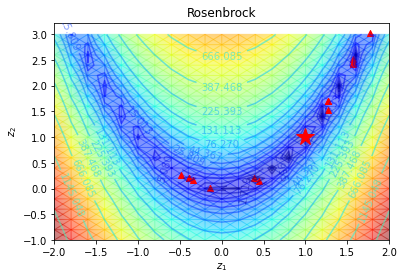

In [51]:
#Representation of the individuals
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,PowerNorm
import matplotlib.colors as colors
xmin, xmax, xstep = -2., 2., .2
ymin, ymax, ystep = -1., 3., .2
X, Y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
##### Plot Rosenbrock 2D ######
plt.figure()
z_rosenbrock = np.array([Rosenbrock(np.array([x,y])) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z_rosenbrock  = z_rosenbrock.reshape(X.shape)
CS=plt.contour(X, Y, Z_rosenbrock, levels=np.logspace(0, 8, 35), norm=LogNorm(), cmap=plt.cm.jet,alpha=0.5)
plt.plot([Optimum_Rosenbrock[0]],[Optimum_Rosenbrock[1]], 'r*', markersize=18)
plt.clabel(CS,inline=1,fontsize=10)
plt.pcolormesh(X,Y,Z_rosenbrock,shading='gouraud',norm=PowerNorm(gamma=0.3),cmap=plt.cm.jet,alpha=0.5)
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Rosenbrock')

plt.scatter([candidate[0] for candidate in (final_pop)],[candidate[1] for candidate in (final_pop)],marker='^', c='red')

# Exercice on Genetic Algorithm
On the Rosenbrock and Ackley functions :
- Test different crossover and mutation probabilities and answer the following questions: 

- What effect implies a crossover probabilty that is small with respect to the mutation probability?

- What is the effect of a mutation probability equal to 0?

- Test different approches for replacement and selection :

- What is the effect of elitist replacement and selection? 

## 2- Use of Inspyred package
Inspyred is apython library that allows the use of several population based algorithms such as GA, PSO, $\textit{etc}$. It involves a particular structure of problem definition.

### Problem definition
An optimization problem is defined using a classe. We have to specify the dimension, the bounds, the generation of the initial propulation, the evaluation operator and the nature of the optimization probelm (minimization or maximization).

In [21]:
from inspyred.benchmarks import Benchmark
import inspyred
from inspyred import ec
from random import Random
from time import time
class Rosenbrock_pb(Benchmark):
    def __init__(self, dimensions=2): #  initialization, problem dimension
        Benchmark.__init__(self, dimensions)
        self.bounder = ec.Bounder([-2.0,-1.0], [2.0,3.0]) # bounds of the variables
        self.maximize = False # minimisation
        self.global_optimum = [1 for _ in range(self.dimensions)]
    
    def generator(self, random,args): # generation of initial population
        return [random.uniform(-2.0, 2.0) , random.uniform(-1.0, 3.0)] #random generation
        
    def evaluator(self, candidates, args=0): # evaluation of points
        fitness = []
        for c in candidates:
            total = 0
            for i in range(len(c) - 1):
                total += 100 * (c[i]**2 - c[i+1])**2 + (c[i] - 1)**2 # Rosenbrock function
            fitness.append(total)
        return fitness

### Genetic algorithm with Inspyred
Inspyred provides a list of predefined functions for the selection, crossover, mutation and replacement. It is also possible to defini the probabilities of mutation and cross over.
#### Selection operators: 
- `default_selection`: selection of the all the population
- `truncation_selection`: selection of the best individuals
- `uniform_selection`: random selection 
- `fitness_proportionate_selection`: selection based on a roulette wheel according to the fitness
- `rank_selection`: selection over the rank
- `tournament_selection`: sselection by tournament
#### Crossover operators:
- `n_point_crossover`: This function performs n-point crossover (NPX). It selects *n* random points without replacement at which to 'cut' the candidate solutions and recombine them.
- `uniform_crossover`: This function performs uniform crossover (UX). For each element of the parents, a biased coin is flipped to determine whether the first offspring gets the 'mom' or the 'dad' element.
- `partially_matched_crossover`: This function performs partially matched crossover (PMX). This type ofcrossover assumes that candidates are composed of discrete values that the permutations of a given set (typically integers). It produces offspring hat are themselves permutations of the set.
- `Arithmetic_crossover`: This function performs arithmetic crossover (AX), which is similar to a generalized weighted averaging of the candidate element
- `heuristic_crossover`: It performs heuristic crossover (HX), which is similar to the update rule used in particle swarm optimization.
- `simulated_binary_crossover`: This function performs simulated binary crossover (SBX), following the implementation in NSGA-II 
- `laplace_crossover`:  This function performs Laplace crosssover (LX), following the implementation specified in (Deep and Thakur, "A new crossover operator for real coded genetic algorithms," Applied Mathematics and Computation, Volume 188, Issue 1, May 2007, pp. 895--911).
#### Mutation operators
- `bit_flip_mutation`: This function performs bit-flip mutation. If a candidate solution contains non-binary values, this function leaves it unchanged.
- `gaussian_mutation`: This function performs Gaussian mutation. 
- `nonuniform_mutation`:  The function performs nonuniform mutation.
#### Replacement operators:
- `truncation_replacement`: selection of the best individuals
- `generational_replacement`: replacement of the parent generation by the offsprings
- `random_replacement`: random replacement


In [22]:
# Definition of GA algorithm with Inspyred
prng = Random()
prng.seed(time()) 
problem = Rosenbrock_pb(2)
ea = inspyred.ec.GA(prng)
ea.terminator = inspyred.ec.terminators.evaluation_termination
final_pop = ea.evolve(generator=problem.generator, #generation function
                      evaluator=problem.evaluator,  #evaluation function
                      pop_size=100,
                      maximize=problem.maximize,  #maximization or minimization
                      bounder=problem.bounder,  #Bounds on the variables
                      max_evaluations=2000,
                      crossover_rate=0.9,
                      mutation_rate=0.99,
                      selector = inspyred.ec.selectors.tournament_selection, #Choice of the selection process
                      variator=[inspyred.ec.variators.crossovers.n_point_crossover,inspyred.ec.variators.mutators.bit_flip_mutation], # choices of the crossover and mutation process
                      replacer=inspyred.ec.replacers.generational_replacement)# choice of the replacement process

In [23]:
print(final_pop[0])

[1.2396874105888207, 1.5257916722527534] : 0.06962321322672999


`ea.evolve`returns the final population. Each element contains the coordinates of the individuals and the corresponding fitness.

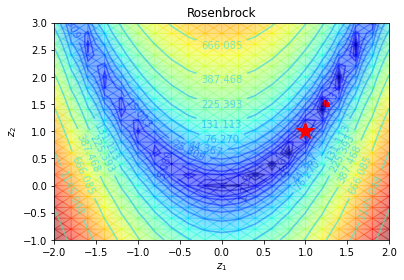

In [24]:
#Representation of the individuals
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,PowerNorm
import matplotlib.colors as colors
f=Rosenbrock_pb(2)
xmin, xmax, xstep = -2., 2., .2
ymin, ymax, ystep = -1., 3., .2
X, Y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
##### Plot Rosenbrock 2D ######
plt.figure()
z_rosenbrock = np.array([f.evaluator([np.array([x,y])]) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z_rosenbrock  = z_rosenbrock.reshape(X.shape)
CS=plt.contour(X, Y, Z_rosenbrock, levels=np.logspace(0, 8, 35), norm=LogNorm(), cmap=plt.cm.jet,alpha=0.5)
plt.plot([Optimum_Rosenbrock[0]],[Optimum_Rosenbrock[1]], 'r*', markersize=18)
plt.clabel(CS,inline=1,fontsize=10)
plt.pcolormesh(X,Y,Z_rosenbrock,shading='gouraud',norm=PowerNorm(gamma=0.3),cmap=plt.cm.jet,alpha=0.5)
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Rosenbrock')

plt.scatter([candidate.candidate[0] for candidate in (final_pop)],[candidate.candidate[1] for candidate in (final_pop)],marker='^', c='red')


### Implementation of Particle Swarm Optimization with Inspyred

Inspyred also provides PSO algorithms. 
- The following syntax allows to define the algorithm `ea = inspyred.swarm.PSO(prng)` 
- he following syntax allows to define the PSO topology: `ea.topology = inspyred.swarm.topologies.ring_topology`. Two choices are possible: 
    - `ring_topology`: This function defines all the particles of a part of the design space as neighbors.
    - `star_topology`: All the particles are considered as neighbors.
- The following syntax allows to perform the evolution of the particle swarm:

    `final_pop= ea.evolve(generator=problem.generator,
                      evaluator=problem.evaluator, 
                      pop_size=30,
                      bounder=problem.bounder,
                      maximize=problem.maximize,
                      max_evaluations=400,
                      social_rate=0.4,
                      cognitive_rate= 0.4,
                      inertia_rate=0.4)`


In [66]:
ea = inspyred.swarm.PSO(prng)
ea.terminator = inspyred.ec.terminators.evaluation_termination
ea.topology = inspyred.swarm.topologies.ring_topology
final_pop= ea.evolve(generator=problem.generator,
                      evaluator=problem.evaluator, 
                      pop_size=30,
                      bounder=problem.bounder,
                      maximize=problem.maximize,
                      max_evaluations=1000,
                      social_rate=0.4, #choix de la valeur du paramètre social
                    cognitive_rate= 0.4, #choix de la valeur du paramètre cognitif
                    inertia_rate=0.8)#choix de la valeur du paramètre d'inertie

In [67]:
final_pop[0]

<Individual: candidate = [0.45480762929594365, 0.20424073103766446], fitness = 0.2979155389142501, birthdate = 1604500050.1465273>

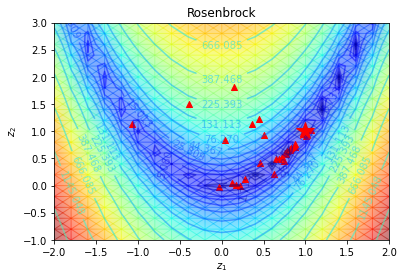

In [27]:
#Visualization on the Rosenbrock function

f=Rosenbrock_pb(2)
xmin, xmax, xstep = -2., 2., .2
ymin, ymax, ystep = -1., 3., .2
X, Y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
##### Plot Rosenbrock 2D ######
plt.figure()
z_rosenbrock = np.array([f.evaluator([np.array([x,y])]) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z_rosenbrock  = z_rosenbrock.reshape(X.shape)
CS=plt.contour(X, Y, Z_rosenbrock, levels=np.logspace(0, 8, 35), norm=LogNorm(), cmap=plt.cm.jet,alpha=0.5)
plt.plot([Optimum_Rosenbrock[0]],[Optimum_Rosenbrock[1]], 'r*', markersize=18)
plt.clabel(CS,inline=1,fontsize=10)
plt.pcolormesh(X,Y,Z_rosenbrock,shading='gouraud',norm=PowerNorm(gamma=0.3),cmap=plt.cm.jet,alpha=0.5)
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Rosenbrock')
plt.scatter([candidate.candidate[0] for candidate in (final_pop)],[candidate.candidate[1] for candidate in (final_pop)],marker='^', c='red')


# Exercice :
- On  Rosenbrock and Ackley :
    - Test different values for `social_rate`, `cognitive_rate` and `inertia_rate`, and conclude on the impact of the parameters on the trade off exploration / exploitation.

## 3- Handling of constraints

The approaches considered before are unconstrained. In this section, constraints are considered to illustrate several methods to handle them.

We consider a constraint$g(\textbf{z})$ as feasible in  $\textbf{z}$ iif  $g(\textbf{z})\leq 0$

One defines two constraints: 
- $g1(\textbf{z})=z_2-z_1-1 \leq 0$
- $g2(\textbf{z})=z_2-z_1^2-0.5  \leq 0 $

In [28]:
def g1(z):
    return z[1]-z[0]-1
def g2(z):
    return z[1]-z[0]**2-0.5

### Penalization methods
The penalization takes into account the constraints by modifying the objective function as follows:
$\tilde{f}(\textbf{z}) = f(\textbf{z}) + p(\textbf{z})$

$p(\textbf{z})$ is a function of the constriant violation $res(\textbf{z})$. 

In [29]:
# definition of the violation function of the constraints
def res(x,*constraints):
    sigma = 0
    for constraint in constraints:
        sigma += np.min((0,constraint(x)))
    return sigma

In [30]:
#Death penalty
def mort_subite(x, f, res, *constraints):
    if res(x,*constraints)==0:
        return f(x)
    else:
        return 10000

In [31]:
#Static penalty
def pena_statique(x, f, res, K, *constraints):
    if res(x,*constraints)==0:
        return f(x)
    else:
        return f(x) + K * res(x,*constraints)

### Handling of the constraints by 'constraint dominance' technique
- A feasible candidate is always prefered to an unfeasible one,
- Between two feasible candidates, the candidate with the best fitness is prefered,
- Between two unfeasible candidates, the candidate that violates the less the constraints is prefered.

In [32]:
#Definition of constriant dominance function
def contrainte_dominance(x, f, res, *constraints):
    if res(x,*constraints)==0:
        return f(x)
    else: 
        return 9000 + res(x,*constraints)

Text(0.5, 1.0, 'Rosenbrock')

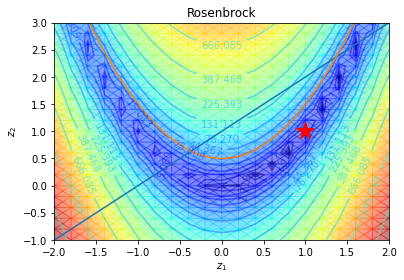

In [33]:
#Illustration son the Rosenbrock function
def Rosenbrock(x):
    return 100*(x[1]-x[0]**2)**2+(1-x[0])**2
f=Rosenbrock
xmin, xmax, xstep = -2., 2., .2
ymin, ymax, ystep = -1., 3., .2
X, Y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
##### Plot Rosenbrock 2D ######
plt.figure()
z_rosenbrock = np.array([f(np.array([x,y])) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z_rosenbrock  = z_rosenbrock.reshape(X.shape)
CS=plt.contour(X, Y, Z_rosenbrock, levels=np.logspace(0, 8, 35), norm=LogNorm(), cmap=plt.cm.jet,alpha=0.5)
plt.plot([Optimum_Rosenbrock[0]],[Optimum_Rosenbrock[1]], 'r*', markersize=18)
plt.clabel(CS,inline=1,fontsize=10)
plt.pcolormesh(X,Y,Z_rosenbrock,shading='gouraud',norm=PowerNorm(gamma=0.3),cmap=plt.cm.jet,alpha=0.5)
t=np.linspace(-2,2,100)
G1=[t[i]+1 for i in range(len(t))]
G2=[t[i]**2+0.5 for i in range(len(t))]
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.plot(t,G1)
plt.plot(t,G2)
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Rosenbrock')


In [34]:
# Definition of genetic algorithm with death penalty
def algo_genetique(f,constraint_handling,res,num_generations,popsize,dim, mini,maxi , proba_crossover,proba_mutation,*constraints):
    new_population = np.random.uniform(low=np.array([-2.0,-1.0]), high=np.array([2.0,3.0]), size=(popsize,dim))
    for generation in range(num_generations):
        fitness = evaluate_population(f,new_population,constraint_handling,res ,*constraints)
        parents = select_parents(new_population,fitness)
        off_spring_crossover = crossover(parents,proba_crossover, mini,maxi)
        off_spring = mutation(off_spring_crossover,proba_mutation)
        new_population = np.concatenate((new_population,off_spring))
        new_population = truncate(f,new_population,constraint_handling,res,*constraints)
    return new_population

def evaluate_population(f, pop,constraint_handling,res,*constraints):
    fitness=np.zeros((len(pop),1))
    for i in range(len(pop)):
        fitness[i] =10000 - constraint_handling(pop[i],f, res, *constraints)
    return fitness

def truncate(f , population,constraint_handling,res,*constraints):
    pop_size=int(len(population)/2)
    fitness=evaluate_population(f, population,constraint_handling,res,*constraints)
    new_generation = np.empty((pop_size, population.shape[1]))
    for pop_num in range(pop_size):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        new_generation[pop_num, :] = population[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return new_generation

In [35]:
final_pop=algo_genetique(Rosenbrock,contrainte_dominance,res,50,20,2,[-2.,-1.],[2.,3.],0.9,0.8,g1,g2)
fitness=evaluate_population(Rosenbrock, final_pop,contrainte_dominance,res)

<ipython-input-16-adfc91b3c07e>:17: RuntimeWarning: divide by zero encountered in double_scalars
  beta = 1.0 + 2 * min(m - lb, ub - d) / float(d - m)


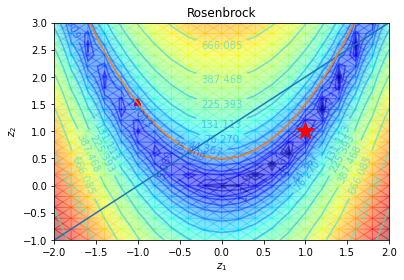

In [36]:
#Illustration son the Rosenbrock function
def Rosenbrock(x):
    return 100*(x[1]-x[0]**2)**2+(1-x[0])**2
f=Rosenbrock
xmin, xmax, xstep = -2., 2., .2
ymin, ymax, ystep = -1., 3., .2
X, Y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
##### Plot Rosenbrock 2D ######
plt.figure()
z_rosenbrock = np.array([f(np.array([x,y])) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z_rosenbrock  = z_rosenbrock.reshape(X.shape)
CS=plt.contour(X, Y, Z_rosenbrock, levels=np.logspace(0, 8, 35), norm=LogNorm(), cmap=plt.cm.jet,alpha=0.5)
plt.plot([Optimum_Rosenbrock[0]],[Optimum_Rosenbrock[1]], 'r*', markersize=18)
plt.clabel(CS,inline=1,fontsize=10)
plt.pcolormesh(X,Y,Z_rosenbrock,shading='gouraud',norm=PowerNorm(gamma=0.3),cmap=plt.cm.jet,alpha=0.5)
t=np.linspace(-2,2,100)
G1=[t[i]+1 for i in range(len(t))]
G2=[t[i]**2+0.5 for i in range(len(t))]
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.plot(t,G1)
plt.plot(t,G2)
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Rosenbrock')
plt.scatter([candidate[0] for candidate in (final_pop)],[candidate[1] for candidate in (final_pop)],marker='^', c='red')

### Exercice 

Test the different constraint handling methods for handling the constraints.
